# Urban Sound Multiclass Classifier
### ML1020 - Machine Learning at Scale - 2019

#### Vadim.S. and Murlidhar.L

### Abstract:
The main objective of this project work is the case study of urban sounds audio event identification and classification.
This is a supervised learning where we will be working on an audio event dataset with samples of audio data that belong to specific categories (which are the sources of the sounds).

We will be leveraging concepts from transfer learning and deep learning to build a robust classifier whereby, with any given audio sample belonging to one of our pre-determined categories, we should be able to correctly predict the source of this sound. The dataset we will be using is popularly known as the UrbanSound8K dataset.
UrbanSounds8K dataset has 8,732 labeled audio sound files (the duration of which are usually equal to or greater than 4 seconds) that contain excerpts from common urban sounds.


### Approach:
Document the steps we plan for our approach - either documentation or a diagram - need to finalize


## Data Analysis

The dataset is downloaded from Kaggle. (to provide the download url)

Let's load the train data and explore available classes and sample distirubtion between the classes. note: the test data is not labled thus it is useless for the training purpose. We have no choice but employ the train dataset to train and validate the model.
The librosa module is an open source Python framework for audio and music analysis.
We will be using this for analyzing as well as extracting features from audio data in subsequent sections.

In [1]:
# import required lbraries
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display
import soundfile as sf
import glob
import random

# define the path relative to the notebook source
# expected data structure
# -----------------------------------------------
# project root
#  src
#    main.ipynb
#  data
#   original
#     audio
#       fold1
#         *.wav
#       fold2,
#         *.wav
#     metadata
#      UrbanSound8K.csv

DATA_PATH = "../data/original/"
META_FILE = "{0}{1}".format(DATA_PATH,"metadata/UrbanSound8k.csv")
# Read the metadata
metaData = pd.read_csv(META_FILE,sep = ',',header=0,names=['FileName','fsID','start','end','salience','fold',
    'ClassID', 'Class'], usecols=[0,6,7])

In [2]:
metaData.head(20)

,FileName,ClassID,Class
0,100032-3-0-0.wav,3,dog_bark
1,100263-2-0-117.wav,2,children_playing
2,100263-2-0-121.wav,2,children_playing
3,100263-2-0-126.wav,2,children_playing
4,100263-2-0-137.wav,2,children_playing
5,100263-2-0-143.wav,2,children_playing
6,100263-2-0-161.wav,2,children_playing
7,100263-2-0-3.wav,2,children_playing
8,100263-2-0-36.wav,2,children_playing
9,100648-1-0-0.wav,1,car_horn


In [3]:
metaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 3 columns):
FileName    8732 non-null object
ClassID     8732 non-null int64
Class       8732 non-null object
dtypes: int64(1), object(2)
memory usage: 204.7+ KB


Let's examine what classes are available

In [4]:
classes = metaData.Class.unique()
classes

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [5]:
print("Number of classes: {0}".format(len(classes)))

Number of classes: 10


As per the output above the dataset comprises ten urban sound classes. It is time to take a look at the class population.

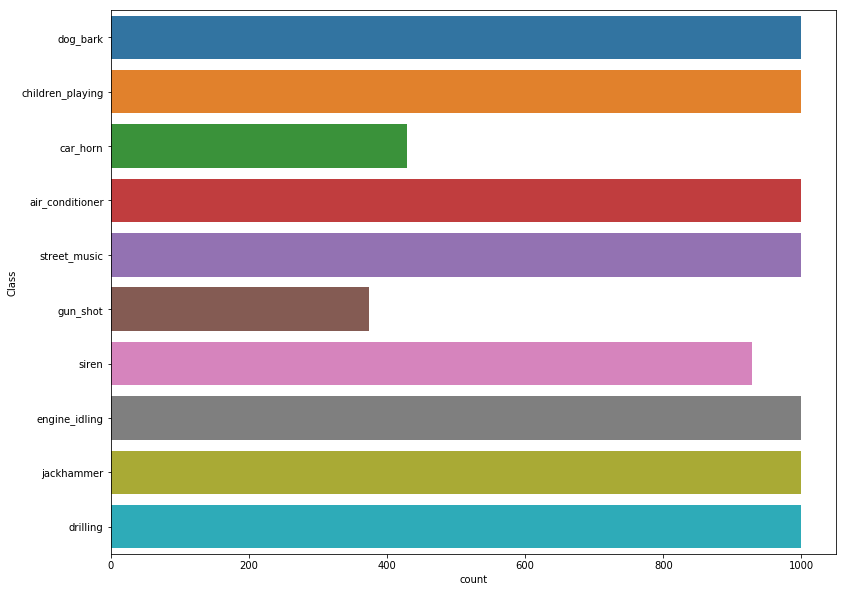

In [6]:
plt.figure(figsize=(13,10))
p = sns.countplot(data=metaData,y='Class')

`Gun Shot` and `Car Horn` categories are underpopulated. We could: 

* digitize and upsample these categories
* upsample all categories
* add more labeled observations to the smaller categories
* leave as is hoping that the categories with the smaller population stil have enough to train the network


### Basic Data Stats

Let's explore the sound smaples in depth. Knowning the sample duration ,sample, rate, number of channels, ec. will help us to understnad what the data normalization and prepration must be done prior to feeding the data to a model. We start with the extraction of sound characteristics of each sample...  

In [7]:
# grab the full paths of all sample files
paths = glob.glob("{0}/audio/**/*".format(DATA_PATH))
# create a dataframe
sounds = [] 
for path in paths:
    fn = os.path.basename(path)
    meta = metaData[metaData.FileName == fn]
    audio = sf.SoundFile(path)
    sounds.append((meta.ClassID.values[0] , meta.Class.values[0],meta.FileName.values[0], audio.channels, 
        audio.samplerate,audio.frames,audio.format, round(audio.frames/audio.samplerate,1),
        audio.subtype,path))
df = pd.DataFrame(sounds,columns=['ClassID','Class','FileName','Channels','SampleRate','Frames','Format',
                                  'Length','SubType','Path'])
df.head(20)

,ClassID,Class,FileName,Channels,SampleRate,Frames,Format,Length,SubType,Path
0,3,dog_bark,101415-3-0-2.wav,1,48000,192000,WAV,4.0,PCM_16,../data/original//audio\fold1\101415-3-0-2.wav
1,3,dog_bark,101415-3-0-3.wav,1,48000,192000,WAV,4.0,PCM_16,../data/original//audio\fold1\101415-3-0-3.wav
2,3,dog_bark,101415-3-0-8.wav,1,48000,192000,WAV,4.0,PCM_16,../data/original//audio\fold1\101415-3-0-8.wav
3,3,dog_bark,102106-3-0-0.wav,2,44100,72324,WAV,1.6,PCM_16,../data/original//audio\fold1\102106-3-0-0.wav
4,6,gun_shot,102305-6-0-0.wav,2,44100,115101,WAV,2.6,PCM_16,../data/original//audio\fold1\102305-6-0-0.wav
5,3,dog_bark,102842-3-0-1.wav,2,44100,176400,WAV,4.0,PCM_16,../data/original//audio\fold1\102842-3-0-1.wav
6,3,dog_bark,102842-3-1-0.wav,2,44100,176400,WAV,4.0,PCM_16,../data/original//audio\fold1\102842-3-1-0.wav
7,3,dog_bark,102842-3-1-5.wav,2,44100,176400,WAV,4.0,PCM_16,../data/original//audio\fold1\102842-3-1-5.wav
8,3,dog_bark,102842-3-1-6.wav,2,44100,176400,WAV,4.0,PCM_16,../data/original//audio\fold1\102842-3-1-6.wav
9,7,jackhammer,103074-7-0-0.wav,2,48000,192000,WAVEX,4.0,PCM_24,../data/original//audio\fold1\103074-7-0-0.wav


#### Sample Rate Distirbution

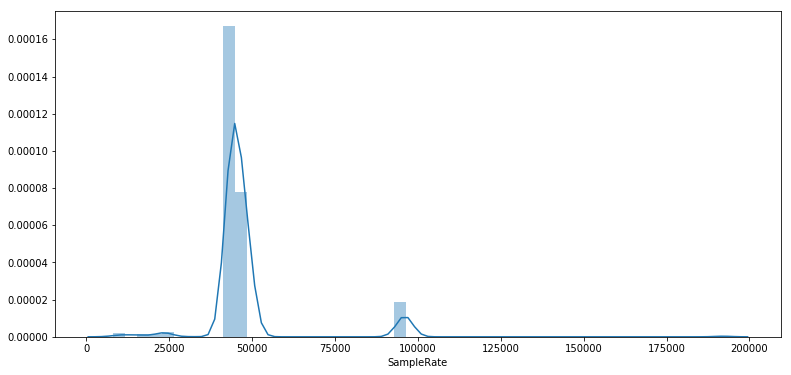

In [8]:
plt.figure(figsize=(13,6))
sns.distplot(df.SampleRate);

Evidently the sample rate of the sound files varies. We would have to resample the original data to bring it to the same standard. Let's caclulate the length of the sounds

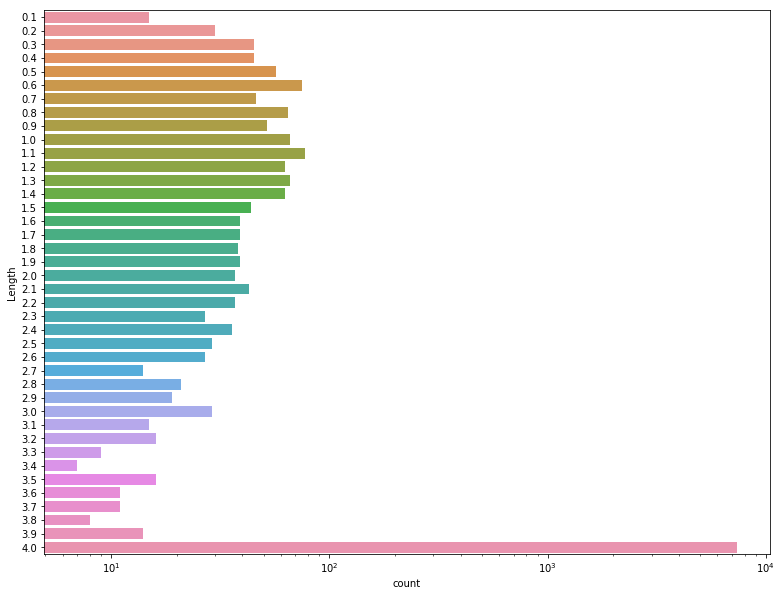

In [9]:
plt.figure(figsize=(13,10))
sns.countplot(y=df.Length, log=True);

Majority of the sound files are 4 second long. But there are some file that are less than a second long. Designing the model we would have to make sure that the input layer is able to deal with the sound samples of various length and a sample rate. We might also filter out the samples that less than 0.5 second long, because most likely they do not carry to valuable information. Lastly we are going to verify how many channles the recoded audio file have (stereo vs mono)

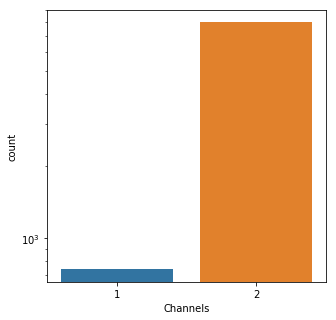

In [10]:
plt.figure(figsize=(5,5))
sns.countplot(x=df.Channels, log=True);

Just a few audo files were recorded in mono. For model training we porbably would need just one channel (TBD)


#### Sound Characteristics of Each Category 

There are ten sound classess. Let's take a sample from each class and review its characteristics.
**Note:** we will be using librosa library to visualize the feautres of the audio sample.

In [11]:
sampleDf=df.groupby('Class',as_index = False,group_keys=False).apply(lambda s: s.sample(1,replace=True))
sampleDf

,ClassID,Class,FileName,Channels,SampleRate,Frames,Format,Length,SubType,Path
4532,0,air_conditioner,100852-0-0-18.wav,2,44100,176400,WAV,4.0,PCM_16,../data/original//audio\fold5\100852-0-0-18.wav
8324,1,car_horn,180156-1-1-0.wav,2,48000,68160,WAVEX,1.4,PCM_24,../data/original//audio\fold9\180156-1-1-0.wav
5064,2,children_playing,190893-2-0-27.wav,2,44100,176400,WAV,4.0,PCM_16,../data/original//audio\fold5\190893-2-0-27.wav
6701,3,dog_bark,183992-3-0-6.wav,2,44100,176400,WAV,4.0,PCM_16,../data/original//audio\fold7\183992-3-0-6.wav
752,4,drilling,57584-4-0-1.wav,2,44100,176400,WAV,4.0,PCM_16,../data/original//audio\fold1\57584-4-0-1.wav
3066,5,engine_idling,195451-5-0-7.wav,2,44100,176400,WAV,4.0,PCM_16,../data/original//audio\fold3\195451-5-0-7.wav
2065,6,gun_shot,174293-6-0-0.wav,2,48000,118080,WAV,2.5,PCM_16,../data/original//audio\fold2\174293-6-0-0.wav
519,7,jackhammer,180937-7-3-30.wav,2,96000,384000,WAVEX,4.0,PCM_24,../data/original//audio\fold1\180937-7-3-30.wav
3150,8,siren,22601-8-0-5.wav,2,48000,192000,WAV,4.0,PCM_16,../data/original//audio\fold3\22601-8-0-5.wav
7563,9,street_music,189825-9-0-1.wav,2,44100,176400,WAV,4.0,PCM_16,../data/original//audio\fold8\189825-9-0-1.wav


Out of curiosity let's listen a few sounds from our sample collection

**Drilling**

In [12]:
IPython.display.Audio(data=sampleDf[sampleDf.Class == 'drilling'].Path.values[0])

**Children Playing**

In [13]:
IPython.display.Audio(data=sampleDf[sampleDf.Class == 'children_playing'].Path.values[0])

#### Visualize Data

Let's now visualize what these different audio sources look like by plotting their waveforms.
This will be a waveform amplitude plot for each audio sample:

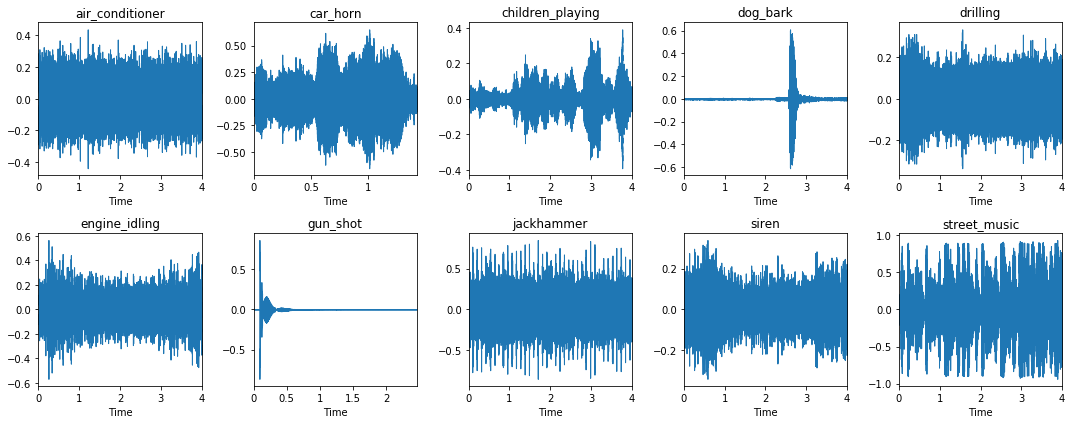

In [14]:
audio=[sf.read(path) for path in sampleDf["Path"]]
i = 0
fig = plt.figure(figsize=(15, 6))
for sample in audio:
    plt.subplot(2, 5, i+1)
    y = librosa.resample(sample[0].T, sample[1], 22050)
    y = librosa.to_mono(y)
    librosa.display.waveplot(y)
    plt.title(sampleDf["Class"].iloc[[i]].values[0])
    i += 1
plt.tight_layout()

The waveform charts rendered above clearly show that each sound class has distinctive characterisitcs, such as rhythm, amplitude, etc.
Though some classes are have more similarities than the other, for example `Air Conditioner` and `Engine Idling` feature rather similar, monotonus sound.
Let's apply another popular technique that exposes the features of the sound even better **mel spectogram**.
The name mel comes from the word melody.
This indicates that the scale is based on pitch comparisons.
The melscale is thus a perceptual scale of pitches that have been judged by listeners to be equal in distance from one another.

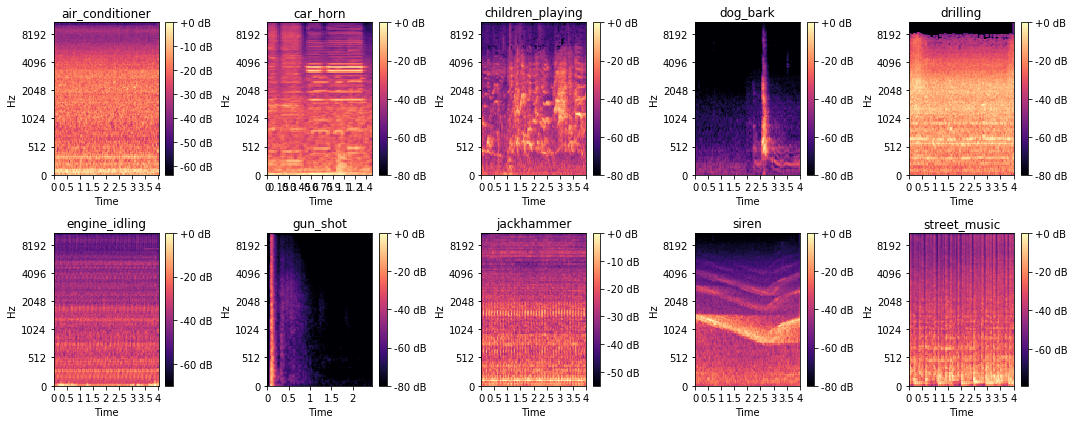

In [15]:
i = 0
fig = plt.figure(figsize=(15, 6))
for sample in audio:
    plt.subplot(2, 5, i+1)
    y = librosa.resample(sample[0].T, sample[1], 22050)
    y = librosa.to_mono(y)
    M = librosa.feature.melspectrogram(y=y)
    librosa.display.specshow(librosa.power_to_db(M, ref=np.max), y_axis='mel', x_axis='time')
    plt.title(sampleDf["Class"].iloc[[i]].values[0])
    plt.colorbar(format='%+02.0f dB')
    i += 1
plt.tight_layout()

Evidently the mel spectograms have more features than the amplitude/time waveform presentation. Now the distiction between the `Engine Idling` and `Air Conditioner` is much clearer. Another advantage of such data presentation that it could be fed to the **Convolutional Neural Network**.

## Data Preprocessing

Considering the finding we discovered during the data exploration phase we are ready to design a feature engineering approach.th

Firstly we shall balance the data set. We can achieve this by applying the augmentation technique to the existing audio samples that belong to `Gun Shot` and `Car Horn` categories. We will introduce random noise, change the pitch and shift time of the audio.


In [133]:
# Sound augmentation procedure
def alterSound(path, sampleRate=22050):
    ya, sr = librosa.load(path,sr=sampleRate)
    # pitch change
    pitch_change =  6*(np.random.uniform())   
    ya = librosa.effects.pitch_shift(ya,sampleRate, n_steps=pitch_change, bins_per_octave=12)
    # time shift
    timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length
    start = int(ya.shape[0] * timeshift_fac)
    if (start > 0):
        ya = np.pad(ya,(start,0),mode='constant')[0:ya.shape[0]]
    else:
        ya = np.pad(ya,(0,-start),mode='constant')[0:ya.shape[0]]
    return ya   
    # add noise
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.01*np.random.uniform()*np.amax(ya)
    ya = ya + noise_amp * np.random.normal(size=ya.shape[0])  
    return ya.astype('float32')
 

In [22]:
pth = sampleDf.Path.values[1]
# original sound
IPython.display.Audio(pth)

In [134]:
altered = alterSound(pth)
IPython.display.Audio(altered, rate=22050)

Let's alter all audios for category 1 - `Car Horn` and 6 - `Gun Shot`. Thus after this step the aforementioned categories will double in size, getting at par with the other categories

In [144]:
def augmentAudio(paths):
    for  path in paths:
        fileName = path.split('\\')[-1].split('.')[0]
        altered = alterSound(path)
        librosa.output.write_wav('../data/generated/{0}{1}.wav'.format(fileName,'_alt'),altered, 22050)

In [145]:
# upsample car_horn(1) and gun_shot (6) . DO THIS ONCE!!!
augmentAudio(glob.glob("{0}/audio/**/*-1-?-*".format(DATA_PATH)))
augmentAudio(glob.glob("{0}/audio/**/*-6-?-*".format(DATA_PATH)))

Considering the fact that the audio files have different length we will sample each audio file using a sliding, overlapping window, which is 500 ms long. This technique allows us to normalize input for our model without loosing to much data. The files that are shorter than 500 ms will be discarded.

We also will resample all audio files applying `22050` Hz sample rate and convert all the files to mono.

## Feature Engineering

Now let's ponder about the features we would have to extract to design a robust classifier. In the past Mel-frequency cepstral coefficients (MFCCs) were considered the best to classify the audio. With the expansion of the Neural Networks multiple research works prove that log-scaled **mel** spectrogram is superior to other features extraction techniques (Ref: [A COMPARISON ON AUDIO SIGNAL PREPROCESSING METHODS FOR DEEP NEURALNETWORKS ON MUSIC TAGGING](https://www.researchgate.net/publication/319534366_A_Comparison_on_Audio_Signal_Preprocessing_Methods_for_Deep_Neural_Networks_on_Music_Tagging)

To capture more data we are going to use 96 mel spectrogram bands and 96 frames for each sample. To build a good classifier we have to find ways to effectively extract useful features from the **mel** spectrograms. There are two approaches. We either:

* train our own feature extraction conlvolutional neural network
* or we opt to employ the power of transfer learning and use pre-train conlvolutional network.

We choose to do the later... One of the pretrained deep learning models that proved to be very effective for feature extraction on images is **VGG-16**. VGG-16 has been trained on RGB images, thus it requires three channel input. The mel spectrogram has one dimension.

There are a few solutions possible

1. Add two more channels during pre-processing, for example log scaled percussion and harmonic sequences as per the book
2. Replicate the spectrogram data twice to form 3-dimensional input
3. Converts spectrogram to lossless image and use it as input for VGG

It seams that the first approach dose not add more data to the model to analyze. The **mel** spectrogram is a lossless presentation of audio. The third option does not enrich data either but introduces additional computation.   So we go with the second approach.

In [123]:
from IPython.core.debugger import set_trace
# windowSize - sample window size in milliseconds
# dimention - dimention of a "band by frame" square

# function to get start and end indices for audio sub-sample
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)
    
#This procesure samples the audio file generates log-scaled mel spectrogram for each sample and labels the samples
# it reurns to array. The first is N "dimention x dimention" log-scaled mel spectorgam band/ frame matrixes.
# The second output value is a vector of labels fo each row in in the firs array
#
# windowSize - sample window size in milliseconds
# dimention - dimention of a "band by frame" square
# sampleRate - sample rate
#
# Example
#
# extractFeatures('test.wav', windowSize = 500, dimention = 96)
def extractFeatures(paths,  sampleRate = 22050,windowSize = 1000, dimention = 64  ):
    hop_length =  int(windowSize/1000 * sampleRate/(dimention - 1))
    window_size = hop_length * (dimention - 1)
    #print("hop lenght: {0}, window size: {1}".format(hop_length,window_size))
    log_specgrams_full = []
    class_labels = []
    # for each audio sample
    for path in paths:
        #set_trace()
        #sound_data, sr = sf.read(path)
        #sound_data = librosa.resample(sound_data.T, sr, sampleRate)
        #sound_data = librosa.to_mono(sound_data)
        sound_data, sr = librosa.load(path,sr=sampleRate)
        soundSize = len(sound_data) - 1
        if (soundSize < window_size):
            continue
        file_name = path.split('\\')[-1]
        class_label =  file_name.split('-')[1]
        # for each audio signal sub-sample window of data
        for (start,end) in windows(sound_data, window_size):
            sample_size = len(sound_data[start:end]);
            tooSmall = sample_size < window_size
            if(tooSmall): # for the last slice get a wnow_size piece from the audo file end
                signal = sound_data[(soundSize-window_size):soundSize]
            else: 
                 signal = sound_data[start:end]
                
            #print("Path: {0} window #: {1} Smaple length: {2}".format(path,count, len(signal)))
            # get the log-scaled mel-spectrogram
            melspec_full = librosa.feature.melspectrogram(signal,n_mels = dimention, 
                                                        sr = sampleRate, hop_length=hop_length)
            logspec_full = librosa.amplitude_to_db(melspec_full)
            logspec_full = logspec_full.T.flatten()[:,np.newaxis].T
            log_specgrams_full.append(logspec_full)
            #print("log_specgrams_full shape: {0}. logspec_full shape: {1}".format(np.shape(log_specgrams_full),
            #        np.shape(logspec_full)))
            class_labels.append(class_label)
            if(tooSmall): #sample size
                break
    # create the first two feature maps
   # set_trace()
    feature = np.asarray(log_specgrams_full).reshape(len(log_specgrams_full), dimention,dimention, 1)
    feature = np.tile(feature,(1,1,1,3))
    return np.array(feature), np.array(class_labels, dtype = np.int)

### Feature Extraction Model (VGG16)

In [34]:
# VGG-16 code sample
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import *

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(96,96,3))
output = vgg.layers[-1].output
output = Flatten()(output)
featureExtractor = Model(vgg.input, output)
featureExtractor.trainable = False
featureExtractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

## Multiclass Classification Model

The classification model will be dealing with the one-dimensional feature vector of size **4608** The output layer is going to be a softmax layer with ten outputs - one for each class.

The classification task seems to be pretty trivial. We will be employing a multi-layer dense perceptron with `Adam` optimizer and categorical cross-entropy loss function. We will insert a few drop layers between the dense ayer to avoid model over-fitting.

In [35]:
# Classifier
from keras.models import Sequential

model = Sequential()
model.add(Dense(300, activation='relu',
input_shape=(4608,)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
optimizer='adam',metrics=['sparse_categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               1382700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              308224    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total para

## Full Production Pipeline in Action

For demonstration purposes I am using a small data set to illustrate the production pipeline in action end-to-end.



In [43]:
# get file path
SAMPLE_DATA_PATH = "../data/original/sample"
paths = glob.glob("{0}/**/*".format(SAMPLE_DATA_PATH))
len(paths)

52

In [44]:
# pre-process audio file
data, labels = extractFeatures(paths,windowSize=500,dimention=96)
print("data shape: {0}. labels shape: {1}".format(np.shape(data), np.shape(labels)))

data shape: (481, 96, 96, 3). labels shape: (481,)


In [45]:
# extract the feures employing VGG-16
data2 = preprocess_input(data)
features = featureExtractor.predict(data2)
print("Features shape: {0}".format(np.shape(features)))

Features shape: (481, 4608)


In [46]:
# Prepare data for the classifier training 
# split into test, validation and training sets
from sklearn.model_selection import train_test_split
train, test, trainLabel, testLabel = train_test_split(features, labels, test_size=0.25, random_state=42)
print("Train shape: {0} Test shape: {1}".format(train.shape,test.shape))

Train shape: (360, 4608) Test shape: (121, 4608)


In [47]:
# train the classification model. Employ Keras automatic validation split
history = model.fit(train, trainLabel, epochs=5, batch_size=128,validation_split=0.33,shuffle=True,
                    verbose=1)

Train on 241 samples, validate on 119 samples
Epoch 1/5
241/241 [==============================] - 1s 5ms/step - loss: 9.2013 - sparse_categorical_accuracy: 0.1743 - val_loss: 5.1393 - val_sparse_categorical_accuracy: 0.3782
Epoch 2/5
241/241 [==============================] - 0s 540us/step - loss: 6.9972 - sparse_categorical_accuracy: 0.3154 - val_loss: 1.9791 - val_sparse_categorical_accuracy: 0.6303
Epoch 3/5
241/241 [==============================] - 0s 497us/step - loss: 5.0942 - sparse_categorical_accuracy: 0.4481 - val_loss: 1.2203 - val_sparse_categorical_accuracy: 0.6807
Epoch 4/5
241/241 [==============================] - 0s 497us/step - loss: 4.2359 - sparse_categorical_accuracy: 0.5021 - val_loss: 1.3539 - val_sparse_categorical_accuracy: 0.7059
Epoch 5/5
241/241 [==============================] - 0s 482us/step - loss: 2.8102 - sparse_categorical_accuracy: 0.5975 - val_loss: 0.8240 - val_sparse_categorical_accuracy: 0.8151


In [105]:
# plot training history. This step is for illustration purpose. GCP will provide all the stats
# history object keys
print(history.history.keys())

dict_keys(['val_loss', 'val_sparse_categorical_accuracy', 'loss', 'sparse_categorical_accuracy'])


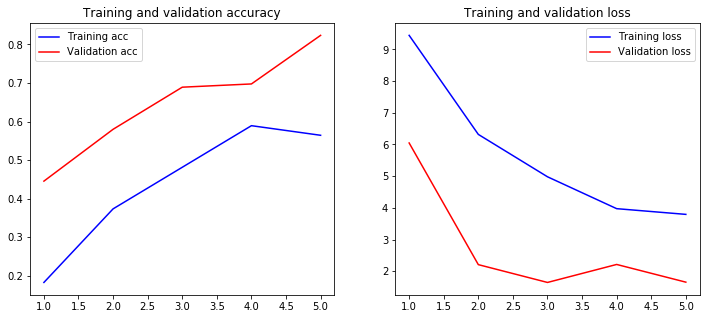

In [107]:
from keras.utils.vis_utils import plot_model

acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']
val_acc = history.history['val_sparse_categorical_accuracy']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
title = 'Training {validation}'
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
modelName = model.name
plot_model(model, show_shapes=True, show_layer_names=True)


In [48]:
loss, accuracy = model.evaluate(test, testLabel, verbose=False)
print("Model Loss: {:.4}; Model Accuracy:  {:.4f}".format(loss, accuracy))


Model Loss: 1.25; Model Accuracy:  0.7769


In [49]:
# note !!! we didi not get 10 categroies because the sample dataset is way too smal.
# After the split into training and test set the training set ended up havig less categories.
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

predictions = model.predict(test)
predictedLabel = np.argmax(predictions, axis=1)
report = metrics.classification_report(testLabel, predictedLabel ) #, target_names=classes
print(report)
#report = confusion_matrix(testLabel, predictedLabel)
#sns.set_context("paper", font_scale=0.9, rc={"lines.linewidth": 1})
#sns.heatmap(pd.DataFrame(report,columns = classes,index = classes ), annot=True, cbar=False)


              precision    recall  f1-score   support

           2       0.57      0.89      0.69        28
           3       0.86      0.49      0.62        37
           5       1.00      1.00      1.00        25
           6       1.00      0.33      0.50         6
           9       0.83      0.96      0.89        25

   micro avg       0.78      0.78      0.78       121
   macro avg       0.85      0.73      0.74       121
weighted avg       0.82      0.78      0.77       121



#### AWS or GCP setup/approach:
We need to outline the approach we plan to take in either GCP or AWS for handling big dataset in cloud.

#### Conclusion:
TODO

#### References:
Book - Hands on Transfer Learning With Puthon - PACKT Publishing
To Add More references